## Bayesian A/B Test Calculator 

This notebook presents step by step instruction how to build a Bayesian A/B Test Calculator with visualization of results using R.

Here is an outline of the project:
### 1. Dataset simulation and  Data manipulation
* To assess the performance of the Bayesina A/B test, I simulate datasets for which true test diferences are known.
* Write functions to process data and compute the cumulative counts and conversions.

### 2. Bayesian A/B test: 
Write functions to do A/B testing for data observed up to a particular day: 
   - Summarize cumulative counts and cumulative conversion rates by group
   - Derive posterior probability, point estimates and credible interval of difference in proportion
   - Perform Bayesian testing using Bayes factors
   - Visualization of prior, and posterior probabilities

### 3. Repeat Bayesian A/B test on cumulative conversion rate over time: 
For all days, perform Bayesian A/B testing using the above functions:
   - When the user select a particular day after the tests begin, give summaries of Bayesian A/B testing
   - Plot the point estimates of difference in proportion, and thier credible interval over time
   - Plot the probability of each test being the best over time
   - Plot the Bayes factor over time 

### 4. Wrap all functions to build a Shiny web app 
Users can use this app to read A/B test data, perform tests, plot the pior and posterior probabilities, monitor the test progress by examing the trend of cumulative conversion rate change over time, and make decisions.

## 1. Dataset simulation and  Data manipulation

### 1.1  Dataset simulation
To assess the performance of the Bayesina A/B test, I simulate datasets with known true parameters to represent the following scenarios:
1. The test group proportion (p1= 0.04)  is different from that of the control group (p0= 0.02);
2. The test group proportion (p2= 0.025) is slightly different from that of control group (p0= 0.02);
3. The test group proportion (p3= 0.02)  is equal to the control group proportion (A/A test).

I start with simple data with only 3 columns: date, group, covert or not. 

In [36]:
# load libraries
library(shiny)
library(dplyr)
library(ggplot2)

### Prior specification
We choose Beta conjugate prior for proportions.
We assume the proportion $\theta \in [0,1] $ is equal for all test groups and follow a common gamma distribution: 
$$\theta \sim B( \alpha_0 , \beta_0) $$ 
where $\alpha_0>0$ , $\beta_0 >0$. 

To start with, I choose $\alpha_0=1$ , $\beta_0=1$, which correspond to a **uniform prior**. 
In future, more appropriate prior hyperparameters can be specified based on information of historical A/B tests. 

In [195]:
## Bayesian prior parameters
alpha_0 = 1
beta_0  = 1

## Set parameters for simulating data

start_date    = as.Date('2017-01-01')  # start date of tests
test_duration = 60    # length of tests in days
num_tests     = 3     # how many test variants excluding default
counts        = 10000 # total view in each group
prob_list     = c(0.02, 0.04, 0.025, 0.02) # true proportion of Test0, Test1, Test2, Test3
alpha         = 0.05  # Confidence level

In [196]:
## Simulate 4 datasets DF0, DF1, DF2, DF3 with true proportion  c(0.02, 0.04, 0.025, 0.02)

set.seed(198911)  #set a random seed so results can be repeat
for (i in 0:num_tests) {
  assign(paste0("DF", i), data.frame(
      Test_group = i, 
      Date = sample(seq(start_date, start_date+ test_duration -1 , by="day"), counts, replace = TRUE ), 
      Convert = rbinom(n = counts, size= 1, prob = prob_list[i+1]))  
        )
}

In [197]:
head(DF1,3)  # Dataset simluated with only 3 columns

Test_group,Date,Convert
1,2017-01-25,0
1,2017-02-12,0
1,2017-01-18,0


### 1.2 Data Manipulation
Write functions to process data and compute 
1. Cumulative counts and cumulative conversion rate
2. Calculate both frequentist confidence interval (CI) and Bayesian credible region (CR)

In [208]:
# A function to do data manipulation

transform_data <- function(df ,   # data frame 
                           a = alpha ,  # confidence level
                           a_0 = alpha_0, b_0= beta_0 # Beta prior parameter
                          ) {
    data = table(df$Date, df$Convert)
    data[,1] = data[,1] + data[,2]

    # calculate the cumulated clicked and cumulated converted
    CumTot  = cumsum(data[,1])
    CumConv = cumsum(data[,2])
    p  =  CumConv/ CumTot 
    
    ## Upper and lower limit of frequentist confidence interval
    Conf_LL =  p - qnorm(1-a/2, mean = 0, sd = 1) * sqrt( p*(1-p)/CumTot  )
    Conf_UL =  p + qnorm(1-a/2, mean = 0, sd = 1) * sqrt( p*(1-p)/CumTot  )
    
    ## Summaries based on posterior probability 
    post_alpha = a_0 + CumConv 
    post_beta  = b_0 + CumTot - CumConv 
    post_mean = (post_alpha)/ ( post_alpha + post_beta ) 
    # compute equal-tailed credible interval for the posterior Beta distribution
    Cred_LL = qbeta( a/2 , shape1 = post_alpha , shape2 = post_beta ) 
    Cred_UL = qbeta(1-a/2, shape1 = post_alpha , shape2 = post_beta )    
    
    data = cbind(Date = as.Date(rownames(data)), as.Date(rownames(data)) - start_date +1, df[1,'Test_group'], data, CumTot  , CumConv, p , Conf_LL, Conf_UL , post_mean, Cred_LL, Cred_UL )
    colnames(data)<- c("Date","Day", "Test_group", "Total","Convert", "Cum_Total", "Cum_Convert", "CRate", 
                       "Conf_LL","Conf_UL" , "Post_mean", "Cred_LL", "Cred_UL")
    
    return(data)
}

## A loop to compute for all DF0- DF3
for (i in 0:num_tests) {
    assign(paste0("CR", i), transform_data(get(paste0("DF", i) ) ) )
}

In [209]:
tail(CR2)

,Date,Day,Test_group,Total,Convert,Cum_Total,Cum_Convert,CRate,Conf_LL,Conf_UL,Post_mean,Cred_LL,Cred_UL
2017-02-24,17221,55,2,192,7,9206,237,0.02574408,0.02250898,0.02897918,0.02584709,0.02270492,0.02918430
2017-02-25,17222,56,2,147,3,9353,240,0.02566022,0.02245573,0.02886470,0.02576162,0.02264865,0.02906660
2017-02-26,17223,57,2,161,2,9514,242,0.02543620,0.02227248,0.02859992,0.02553594,0.02246224,0.02879849
2017-02-27,17224,58,2,166,2,9680,244,0.02520661,0.02208396,0.02832927,0.02530469,0.02227056,0.02852452
2017-02-28,17225,59,2,140,1,9820,245,0.02494908,0.02186424,0.02803393,0.02504582,0.02204828,0.02822650
2017-03-01,17226,60,2,180,5,10000,250,0.02500000,0.02194001,0.02805999,0.02509498,0.02212077,0.02824904


In [214]:
data 

,Date,Day,Test_group,Total,Convert,Cum_Total,Cum_Convert,CRate,Conf_LL,Conf_UL,Post_mean,Cred_LL,Cred_UL
2017-01-01,17167,1,2,152,6,152,6,0.03947368,0.008518402,0.07042897,0.04545455,0.01858971,0.08339948
2017-01-02,17168,2,2,146,4,298,10,0.03355705,0.013110502,0.05400359,0.03666667,0.01850562,0.06064461
2017-01-03,17169,3,2,148,2,446,12,0.02690583,0.011888895,0.04192276,0.02901786,0.01557433,0.04642406
2017-01-04,17170,4,2,179,1,625,13,0.02080000,0.009611408,0.03198859,0.02232855,0.01227939,0.03525002
2017-01-05,17171,5,2,173,5,798,18,0.02255639,0.012254254,0.03285853,0.02375000,0.01437626,0.03537120
2017-01-06,17172,6,2,164,6,962,24,0.02494802,0.015092210,0.03480384,0.02593361,0.01686917,0.03685626
2017-01-07,17173,7,2,160,2,1122,26,0.02317291,0.014369499,0.03197631,0.02402135,0.01590272,0.03374039
2017-01-08,17174,8,2,192,4,1314,30,0.02283105,0.014755015,0.03090709,0.02355623,0.01607238,0.03240877
2017-01-09,17175,9,2,176,6,1490,36,0.02416107,0.016364530,0.03195762,0.02479893,0.01753125,0.03327113
2017-01-10,17176,10,2,156,4,1646,40,0.02430134,0.016862481,0.03174019,0.02487864,0.01792205,0.03292574


### Visualization of trend 
### 1. Frequentist approach: Mean and Confidence Interval

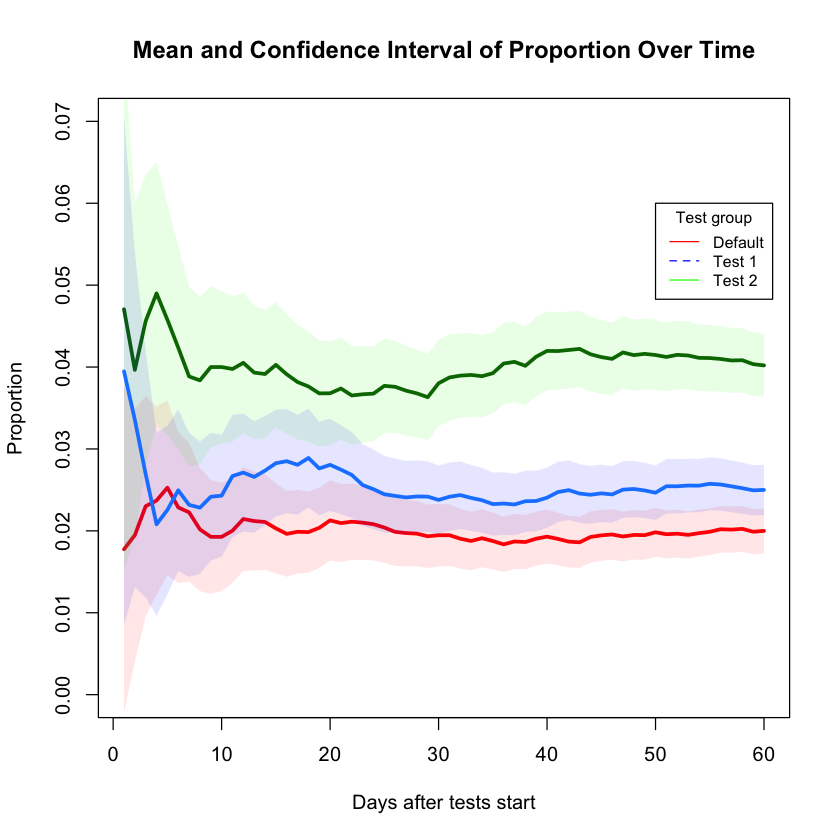

In [236]:
data = CR0
plot(  data[,'Day'],  data[,'CRate'] ,type = "l", lwd = 3, col="red", lty=1 , ylim = c(0,0.07) ,
    main = "Mean and Confidence Interval of Proportion Over Time" , 
    xlab = 'Days after tests start' , ylab= 'Proportion')
polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,'Conf_LL'] , rev(data[,'Conf_UL']) ), 
        col=rgb(1, 0, 0,0.1), border=NA)

data = CR1
lines(  data[,'Day'],  data[,'CRate'] ,type = "l", lwd = 3, col="darkgreen", lty=1    )
polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,'Conf_LL'] , rev(data[,'Conf_UL']) ), 
        col=rgb(0, 1, 0,0.1), border=NA)


data = CR2
lines(  data[,'Day'],  data[,'CRate'] ,type = "l", lwd = 3, col="dodgerblue", lty=1  )
polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,'Conf_LL'] , rev(data[,'Conf_UL']) ), 
        col=rgb(0, 0, 1,0.1), border=NA)


legend(50,  0.06, legend=c("Default", "Test 1", "Test 2"),
       col=c("red", "blue", "green"), lty=1:2, cex=0.8, title="Test group")

### 2. Bayesian approach: Posterior Mean and Credible Interval 

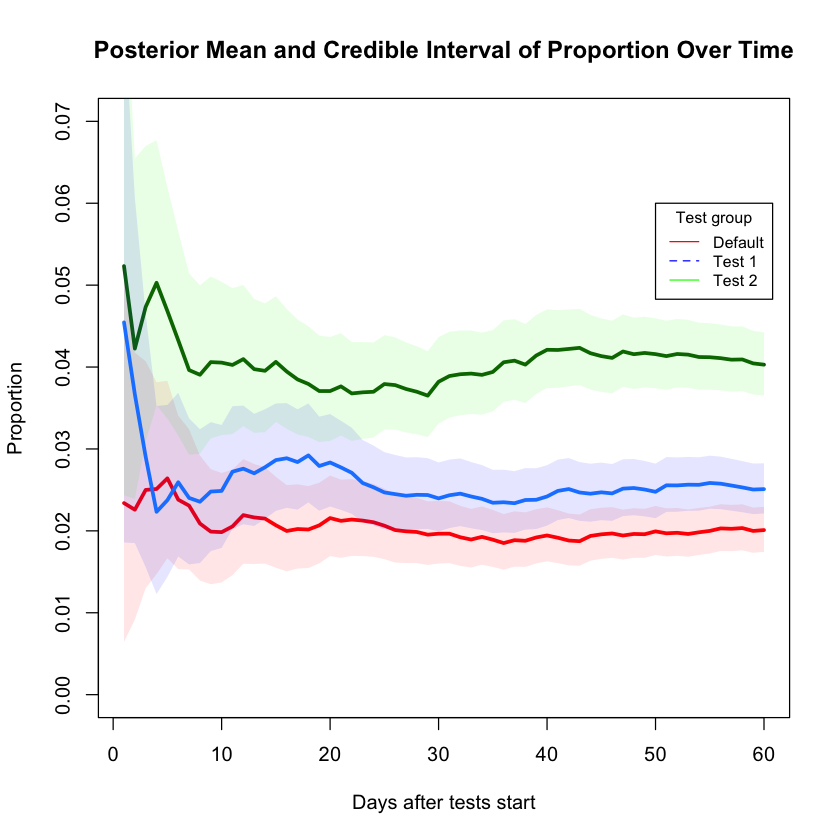

In [235]:
data = CR0
plot(  data[,'Day'], data[,'Post_mean'] ,type = "l", lwd = 3, col="red", lty=1 , ylim = c(0,0.07) ,
    main = "Posterior Mean and Credible Interval of Proportion Over Time" , 
    xlab = 'Days after tests start' , ylab= 'Proportion')
polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,'Cred_LL'] , rev(data[,'Cred_UL']) ), 
        col=rgb(1, 0, 0,0.1), border=NA)

data = CR1
lines(  data[,'Day'], data[,'Post_mean'] ,type = "l", lwd = 3, col="darkgreen", lty=1    )
polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,'Cred_LL'] , rev(data[,'Cred_UL']) ), 
        col=rgb(0, 1, 0,0.1), border=NA)


data = CR2
lines(  data[,'Day'], data[,'Post_mean'] ,type = "l", lwd = 3, col="dodgerblue", lty=1  )
polygon( c(data[,'Day'] , rev(data[,'Day']) ), c(data[,'Cred_LL'] , rev(data[,'Cred_UL']) ), 
        col=rgb(0, 0, 1,0.1), border=NA)


legend(50,  0.06, legend=c("Default", "Test 1", "Test 2"),
       col=c("red", "blue", "green"), lty=1:2, cex=0.8, title="Test group")

### 2. Bayesian A/B test: 
Write functions to do A/B testing for data observed up to a particular day: 
   - Summarize cumulative counts and cumulative conversion rates by group
   - Derive posterior probability, point estimates and credible interval of difference in proportion
   - Perform Bayesian testing using Bayes factors
   - Visualization of prior, and posterior probabilities

### 3. Bayesian A/B test for cumulative conversion rate: 
For any day, perform Bayesian A/B testing using the above functions:
   - When the user select a particular day after the tests begin, give summaries of Bayesian A/B testing
   - Plot the point estimates of difference in proportion, and thier credible interval over time
   - Plot the probability of each test being the best over time
   - Plot the Bayes factor over time 

### 4. Wrap all functions to build a Shiny web app 
The Shiny app will be able to:
1. Read A/B test data (date, group, convert or not)
2. Give the summary of A/B test results for all data and plot the pior and posterior probabilities; 
3. An option to show a list of summary for A/B testing results by a certain interval (e.g. every week)
4. Visualize the cumulative conversion rate change and its credible interval over time 

Start with only 2 groups, say default and test groups:

In [151]:
data12 <- data[data$group <=2, ]
dim(data12)

max_day = as.numeric(max(data$date)- min(data$date)) ; max_day

[1] 106  12

[1] 52

In [179]:
days = 3
alpha = 1
beta  = 1  
bayes_result <- function(days, alpha =1, beta=1 ){
    
    n_total1 = data[data$day == days & data$group==1 , 'cum_clicked']    
    n_total2 = data[data$day == days & data$group==2 , 'cum_clicked']  
    n_conv1  = data[data$day == days & data$group==1 , 'cum_converted'] 
    n_conv2  = data[data$day == days & data$group==2 , 'cum_converted'] 

    # compute prior, pooled likehood and posteriors for male and female:
    theta <-seq(0,1,0.001) #create theta range from 0 to 1
    prior <- dbeta(theta, alpha, beta)

    likelihood1 <- dbinom(n_conv1, size= n_total1 , prob= theta)   
    likelihood2 <- dbinom(n_conv2, size= n_total2 , prob= theta)   

    posterior_1 <- dbeta(theta, alpha + n_conv1, beta + n_total1 - n_conv1 ) 
    posterior_2 <- dbeta(theta, alpha + n_conv2, beta + n_total2 - n_conv2 ) 


    p05_1  = qbeta(p = 0.05, shape1 = alpha + n_conv1 , shape2 = beta + n_total1 - n_conv1, lower.tail = TRUE) 
    p95_1  = qbeta(p = 0.95, shape1 = alpha + n_conv1 , shape2 = beta + n_total1 - n_conv1, lower.tail = FALSE) 
    p05_2  = qbeta(p = 0.05, shape1 = alpha + n_conv2 , shape2 = beta + n_total2 - n_conv2, lower.tail = TRUE) 
    p95_2  = qbeta(p = 0.95, shape1 = alpha + n_conv2 , shape2 = beta + n_total2 - n_conv2, lower.tail = FALSE) 
    
    return n_total1, n_total2, n_conv1 , n_conv2 
    }

ERROR: Error in parse(text = x, srcfile = src): <text>:27:12: unexpected symbol
26:     
27:     return n_total1
               ^


In [178]:
bayes_result(days= 3)

ERROR: Error in return[n_total1, n_total2, n_conv1, n_conv2]: object of type 'special' is not subsettable


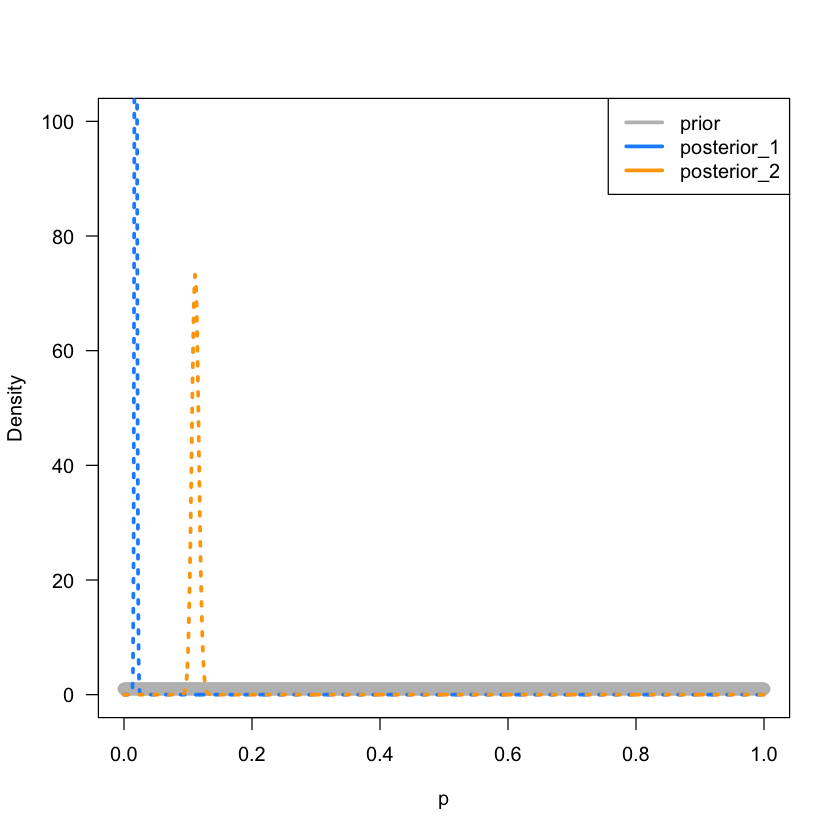

In [152]:
#plot of probabilities
plot(theta, prior, lwd = 3, col="gray", lty=2 , xlab = bquote(p), ylab = "Density", las = 1, ylim = c(0,100))#, xlim=c(0,0.2))
#lines(theta, likelihood1, lwd = 3,type = "l", col="pink")
#lines(theta, likelihood2, lwd = 3,type = "l", col="purple")
lines(theta, posterior_1, lwd = 3, col="dodgerblue", lty=3)
lines(theta, posterior_2, lwd = 3, col="orange", lty=3)
legend("topright",lwd=3,
   c("prior","posterior_1","posterior_2"),
   col = c("grey","dodgerblue","orange")
   )

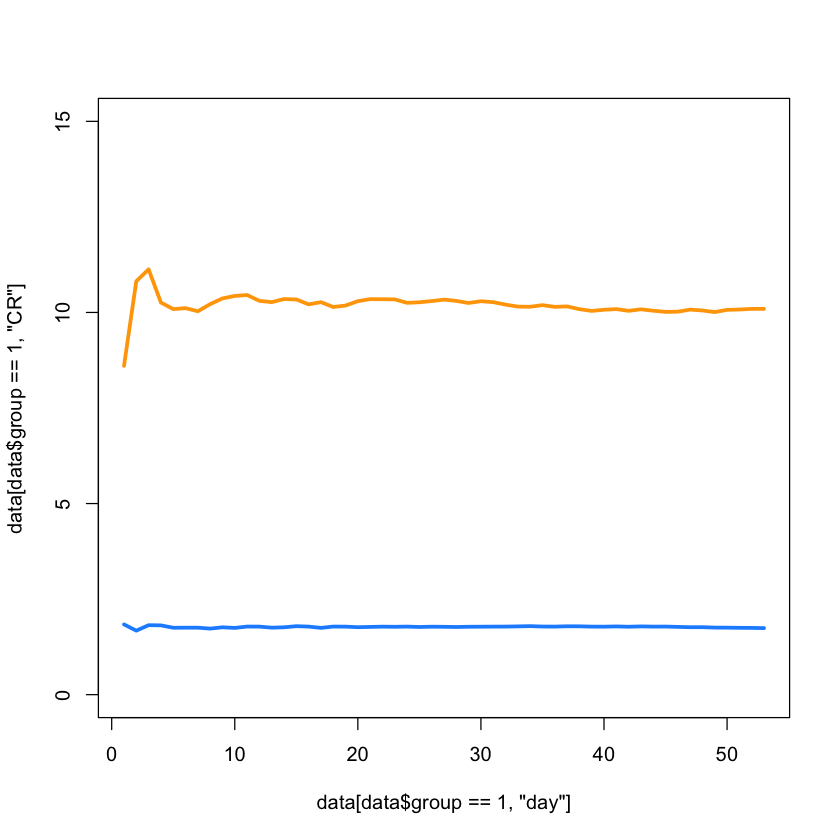

In [146]:
plot( data[data$group==1, 'day'], data[data$group==1, 'CR'] ,type = "l", lwd = 3, col="dodgerblue", lty=1, ylim = c(0,15))
lines(data[data$group==1, 'day'], data[data$group==2, 'CR'] ,type = "l", lwd = 3, col="orange", lty=1)
